In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import pickle
import numpy as np
from imbalance.pipeline import Pipeline
from imbalance.data import gaussian_binary
from imbalance.viz import metric_balance
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from joblib import Parallel, delayed
from matplotlib import pyplot as plt

plt.style.use("seaborn")

In [3]:
x, y, groups = gaussian_binary(mean_distance=1)

In [4]:
classifiers = {
    "lr": {
        "default": LogisticRegression(class_weight=None),
        "balanced": LogisticRegression(class_weight="balanced")
    },
    "svm": {
        "default": SVC(probability=True, class_weight=None),
        "balanced": SVC(probability=True, class_weight="balanced")
        },
    "rf": {
        "default": RandomForestClassifier(n_estimators=25, class_weight=None),
        "balanced": RandomForestClassifier(n_estimators=25, class_weight="balanced"),
        "balanced_subsample": RandomForestClassifier(n_estimators=25, class_weight="balanced_subsample"),
        "min_weight_fraction_leaf=0.05": RandomForestClassifier(n_estimators=25, min_weight_fraction_leaf=0.05),
        "min_weight_fraction_leaf=0.15": RandomForestClassifier(n_estimators=25, min_weight_fraction_leaf=0.15),
        "min_weight_fraction_leaf=0.3": RandomForestClassifier(n_estimators=25, min_weight_fraction_leaf=0.3),
    }
}

In [5]:
def run_pipeline(name, x, y, groups, clf):
    pl = Pipeline(x, y, groups, classifiers=clf, n_permutations=0)
    pl.evaluate()
    return name, pl

pls = {}
for clf_name, clf_list in classifiers.items():
    pls[clf_name] = Parallel(n_jobs=-1)(
        delayed(run_pipeline)(name, x, y, groups, clf) for name, clf in clf_list.items()
    )
    pls[clf_name] = {name: pl for name, pl in pls[clf_name]}

with open("hparams_pipelines.pkl", "wb") as f:
    pickle.dump(pls, f)

fitting classifiers: 100%|██████████| 250/250 [02:48<00:00,  1.49it/s, size=1, balance=0.9, classifier=RandomForestClassifier]  

In [6]:
with open("hparams_pipelines.pkl", "rb") as f:
    pls = pickle.load(f)

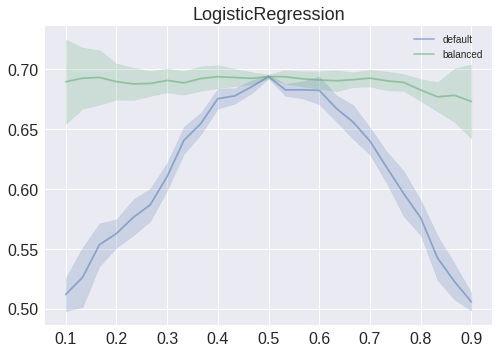

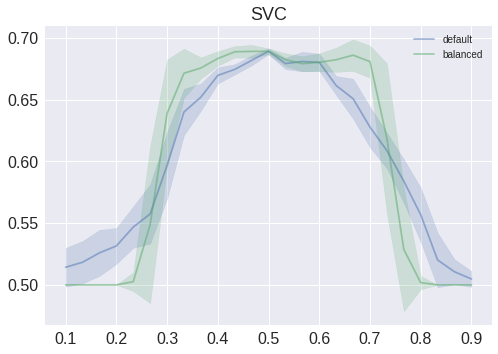

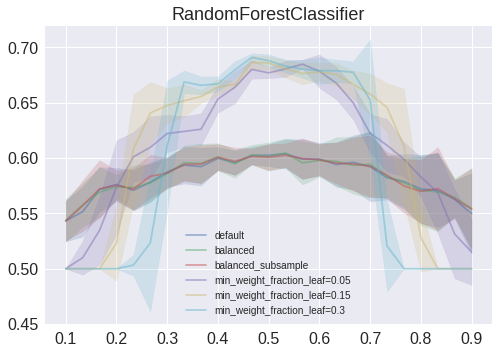

In [9]:
for clf_name in pls.keys():
    fig, ax = plt.subplots()
    lines = []
    for i, curr_pl in enumerate(pls[clf_name].values()):
        lines.extend(metric_balance(curr_pl, classifier=clf_name, color_offset=i, ax=ax, 
                                    ignore_metrics=["roc_auc", "f1", "accuracy"],
                                    show=False, show_leg=False, enforce_ylim=False, reset_colors=True))
    ax.legend(lines, pls[clf_name].keys())
    plt.show()